In [2]:
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
import ast
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    meta_data = data[0][1]
    return data, meta_data


In [4]:
sampling_rate=100
path='/'

Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
X, meta_data = load_raw_data(Y, sampling_rate, path)

In [6]:
print((X[0].T)[10].shape)

(1000,)


In [7]:
print(X.shape[0])
print(X.shape[1])
print(X.shape[2])

21799
1000
12


In [8]:
print((X[0].T).shape[0])
print((X[0].T).shape[1])

12
1000


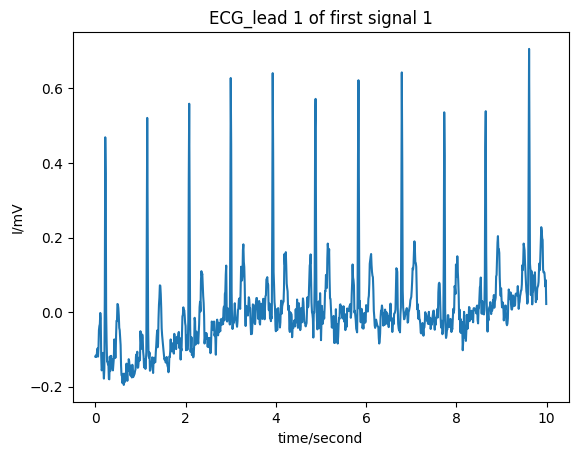

None

In [9]:
# for lead in range(X.shape[2]):
record = wfdb.rdrecord(Y.filename_lr.iloc[0],channels=[0])
display(wfdb.plot_wfdb(record=record, title=f'ECG_lead 1 of first signal {Y.index[0]}'))

(0.0, 400.0)

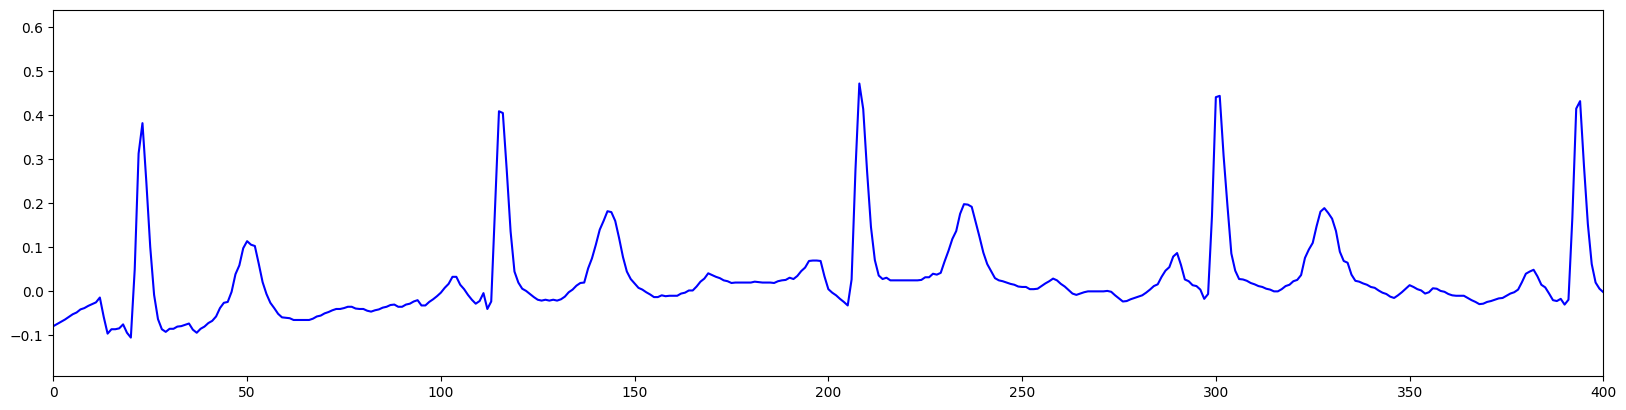

In [10]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[11], color = 'blue')
arr_signal.set_xlim(0, 400)

In [11]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# agg_df.head()

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [12]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [13]:
print('shape of x_train:',X_train.shape)
print('shape of x_test:',X_test.shape)
print('shape of Y_train:',y_train.shape)
print('shape of Y_train:',y_test.shape)

shape of x_train: (19601, 1000, 12)
shape of x_test: (2198, 1000, 12)
shape of Y_train: (19601,)
shape of Y_train: (2198,)


In [14]:
path = Y.filename_lr.iloc[0]
record = wfdb.rdsamp(path)
channels = record[1]['sig_name']
channels

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

Baseline Removal

In [15]:
from scipy.signal import medfilt
# 21799 * 1000 * 12

for signal in range(X.shape[0]):
    for lead in range(X.shape[2]):
            X [signal,:,lead] = medfilt(X [signal,:,lead])

ECG_filtered = X - np.median(X, axis=1 , keepdims=True)

(0.0, 400.0)

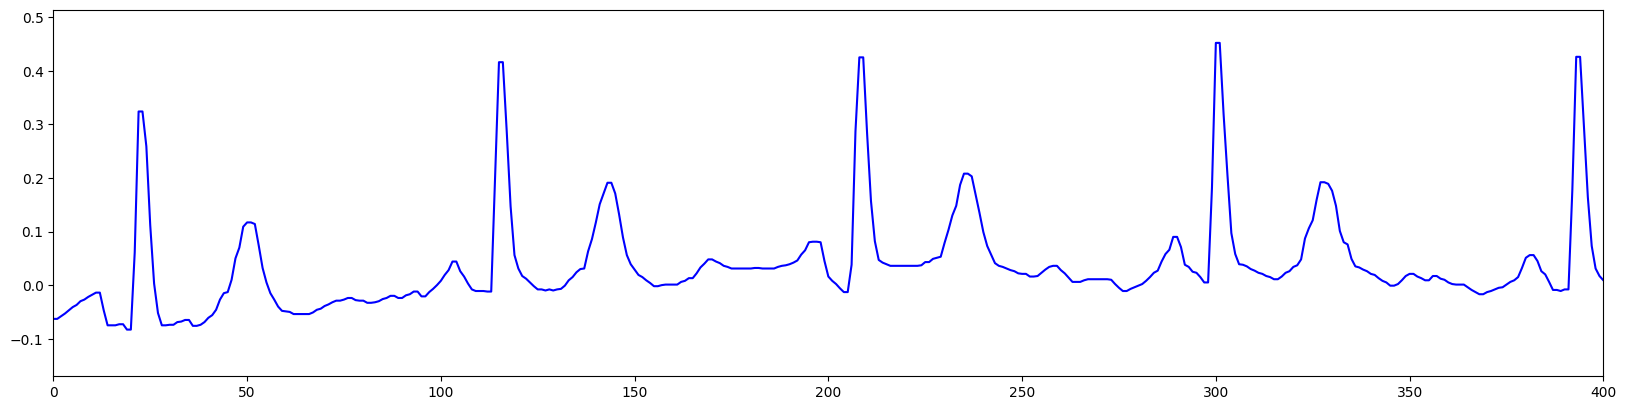

In [16]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((ECG_filtered[0].T)[11], color = 'blue')
arr_signal.set_xlim(0, 400)

In [23]:
from BaselineRemoval import BaselineRemoval

for signal in range(ECG_filtered.shape[0]):
    for lead in range(ECG_filtered.shape[2]):
            
            X  = BaselineRemoval(ECG_filtered [signal,:,lead])
            ECG_baseline_filtered=X.ZhangFit()


# fig = plt.figure(figsize=(20, 20))
# arr_signal = fig.add_subplot(grid[0, 0])
# arr_signal.plot(filtered_sample, color = 'blue')
# arr_signal.set_xlim(0, 400)

WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max iteration reached!
WARING max

FEATURE EXTRACTION

In [18]:
from ecgdetectors import Detectors
detectors = Detectors(sampling_rate)

# Padding to help detect initial peaks:
r_peaks = np.array(detectors.hamilton_detector(np.hstack((np.zeros(10),X_train[0,:,1])))) - 10
r_peaks_wvt = np.array(detectors.swt_detector(np.hstack((np.zeros(20),X_train[0,:,1])))) - 20

print(r_peaks)
print(r_peaks_wvt)

[ 28 120 213 306 399 490 588 685 779 867 963]
[ 19  56 112 199 297 390 484 579 675 770 861 957]


In [19]:
import neurokit2 as nk
u, rpeaks = nk.ecg_peaks(X_train[0,:,1], sampling_rate=sampling_rate)
print(rpeaks)

{'ECG_R_Peaks': array([115, 208, 300, 393, 487, 583, 679, 773, 864, 961]), 'sampling_rate': 100}


In [20]:
import neurokit2 as nk
from ecgdetectors import Detectors
import sys

def advanced_interactive_signal_plot(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32), rpeak_style = 'nk') -> None:
  channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  colors = px.colors.qualitative.Dark24
  for s_idx in idxs: # subject_index:
    X_subject = X[s_idx, :, :]
    scp_code = Y.scp_codes.iloc[s_idx]
    ecg_id = Y.index[s_idx]

    heart_rates = {}

    fig = go.Figure()
    for n_idx, idx in enumerate(channels):
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,idx] + 2. * (len(channels) - n_idx), name = channel_names[idx], marker_color = colors[idx]))
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
      
      # Estimate R-peaks:
      if rpeak_style == 'nk':
        _, rpeaks = nk.ecg_peaks(X_subject[:,idx], sampling_rate=sampling_rate)
        rpeaks = rpeaks['ECG_R_Peaks'].astype('float') / sampling_rate
      elif rpeak_style == 'hamilton':
        detectors = Detectors(sampling_rate)
        rpeaks = (np.array(detectors.hamilton_detector(X_subject[:,idx]))).astype('float')  / sampling_rate # np.hstack((np.zeros(10),
      elif rpeak_style == 'wvt':
        detectors = Detectors(sampling_rate)
        rpeaks = np.array(detectors.swt_detector(X_subject[:,idx])).astype('float') / sampling_rate
      else:
        sys.exit('Incorrect rpeak_style. Options: "nk", "hamilton", "wvt".')

      heart_rates[channel_names[idx]] = (rpeaks.shape[0] - 1) * sampling_rate / (rpeaks[-1] - rpeaks[0]) 

      for r in rpeaks:
        fig.add_trace(go.Scatter(x = r * np.ones(20), y = np.linspace(-1, 1, num = 20) + 2. * (len(channels) - n_idx), line = dict(color = 'grey'), showlegend = False))
    
    fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code} - R-peaks: grey', yaxis = dict(showticklabels=False))
    fig.show()
    display(pd.Series(heart_rates, name = 'heart_rates'))

advanced_interactive_signal_plot([0,1], X_train, y_train, sampling_rate, rpeak_style = 'nk')
     


AttributeError: 'Series' object has no attribute 'scp_codes'